# YT Comments analysis

In [7]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from datetime import datetime, timedelta, time
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from api import API_KEY

channel_id = "UCWeg2Pkate69NFdBeuRFTAw" #Squeezie channel
etoiles = 'UCABf02qOye7XYapcK1M45LQ'
youtube = build('youtube', 'v3', developerKey=API_KEY)
exemple_video = "qCKyRhkhqoQ"
otp_recap = 'F7A8OCdmZ90'

### Class request
Class to handle youtube request since youtube api doesn't provide a request object

In [3]:
class Request:
    """ Class Request handling youtube request as an object """
    def __init__(self, requestType,part=None, id=None, chart=None, regionCode=None, maxResults=None, pageToken=None, videoId=None):
        self.requestType = requestType
        self.part = part
        self.id = id
        self.chart = chart
        self.regionCode = regionCode
        self.maxResults = maxResults
        self.pageToken = pageToken
        self.videoId = videoId
        
    def execute(self):
        param = vars(self) # Fetch class attributes
        param = {x:y for x,y in list(param.items())[1:] if y} # Delete requestType ([1:]) and None attributes
        
        request = self.requestType.list(**param)
        return request.execute()

### Decorator
Decorator to retry when youtube request fails (mostly due to timeout erros)

In [3]:
def retry_on_exception(max_attempts=5):
    def decorator(func):
        def wrapper(*args, **kwargs):
            attempts = 0
            while attempts < max_attempts:
                try:
                    result = func(*args, **kwargs)
                except Exception as e:
                    attempts += 1
                    if attempts == max_attempts:
                        return pd.DataFrame()
                        raise  # Relancer l'exception si le nombre maximal de tentatives est atteint
                    else:
                        print(f"{attempts}: Une exception s'est produite : {e}")
                else:
                    return result  # Retourner le résultat si aucune exception n'est levée
                # time.sleep(0.5)
        return wrapper
    return decorator

### Datetime convertions
Functions to convert iso formated date found in youtube api responses in datetime objects.

In [4]:
def iso_toDatetime(iso_date:str):
    """Converts an ISO 8601 formatted date to a datetime object."""
    return datetime.strptime(iso_date[:-1], '%Y-%m-%dT%H:%M:%S')

def datetime_toISO(dt_obj:datetime):
    """Converts a datetime object to an ISO 8601 formatted date."""
    return dt_obj.isoformat()[:-7]  # remove microseconds

def iso_toDelta(iso_duration:str):
    """Converts an ISO 8601 formatted duration to a timedelta object."""
    match = re.match(r'PT(\d+D)*(\d+H)*(\d+M)*(\d+S)', iso_duration)
    days, hours, minutes, seconds = [int(x[:-1]) if x else 0 for x in match.groups()]
    return timedelta(days=days,hours=hours, minutes=minutes, seconds=seconds)

def delta_toISO(delta_obj:timedelta):
    """Converts a timedelta object to an ISO 8601 formatted duration."""
    hours = delta_obj.seconds // 3600
    minutes = (delta_obj.seconds % 3600) // 60
    seconds = delta_obj.seconds % 60
    
    daysStr = f"{delta_obj.days}D" if delta_obj.days != 0 else ""
    hoursStr = f"{hours}H" if hours != 0 else ""
    minutesStr = f"{minutes}M" if minutes != 0 else ""
    secondsStr = f"{seconds}S" if seconds != 0 else ""
    return f"PT{daysStr}{hoursStr}{minutesStr}{secondsStr}"

# print(iso_toDelta('PT4D3H20M9S'))
# print(delta_toISO(iso_toDelta('PT20M9S')))

### Fectching functions
Functions to fetch channels, comments ant top vids infos.

In [5]:
def format_channel_data(channel_data: dict) -> pd.DataFrame:
    """ Structure raw channel data """
    data = {
        "channel_name": [channel_data.get('snippet', {}).get('title')],
        "channel_id": [channel_data.get('id')],
        "country": [channel_data.get('snippet', {}).get('country',"")],
        **{k:[int(v)] for k,v in channel_data.get('statistics', {}).items() if k != "hiddenSubscriberCount"},
        "topics": [[wikilink.split('/')[-1] for wikilink in channel_data.get('topicDetails', {}).get('topicCategories', [])]],
    }
    return pd.DataFrame.from_dict(data)

In [6]:
def get_channel_data(youtube, channel_id:str) -> dict[str|dict]:
    """ Request (by id) for most important channel stats """
    request = Request(
        requestType=youtube.channels(),
        part="snippet,contentDetails,statistics,topicDetails",
        id=channel_id
    )
    response = request.execute()
    rawData = response.get('items', [])[0]
    return format_channel_data(rawData)
    

get_channel_data(youtube, etoiles)

,channel_name,channel_id,country,viewCount,subscriberCount,videoCount,topics
0,Etoiles,UCABf02qOye7XYapcK1M45LQ,FR,49610169,272000,554,"[Action-adventure_game, Role-playing_video_gam..."


In [7]:
def format_video_data(video_data: dict) -> pd.DataFrame:
    """ Structure raw video data """
    data = {
            "title": [video_data.get('snippet', {}).get('title')],
            "id": [video_data.get('id')],
            "publishedAt": [video_data.get('snippet', {}).get('publishedAt')],
            "duration" : [video_data.get('contentDetails').get('duration')],
            "ViewCount" : [int(video_data.get('statistics', {}).get('viewCount', 0))],
            "likeCount" : [int(video_data.get('statistics', {}).get('likeCount', 0))],
            "commentCount" : [int(video_data.get('statistics', {}).get('commentCount', 0))],  
            "tags" : [video_data.get('snippet', {}).get('tags')]
    }
    
    return pd.DataFrame.from_dict(data)

In [8]:
def get_video_data(youtube, video_Id:str) -> dict[str|dict]:
    """ Request (by id) for most important video stats """
    request = Request(
        requestType=youtube.videos(),
        part="snippet,contentDetails,statistics,topicDetails",
        id=video_Id,
    )
    response = request.execute()
    
    rawData = response.get('items', [])[0]
    return format_video_data(rawData)

get_video_data(youtube, exemple_video)

,title,id,publishedAt,duration,ViewCount,likeCount,commentCount,tags
0,"LE JEU DE LA FÈVE (Avec Joyca, Zafeel et Hctuan)",qCKyRhkhqoQ,2024-02-10T12:02:00Z,PT35M30S,2865841,191434,2099,"[Mastu, Mastus, Humour, Matsu, loat, mastu loa..."


In [9]:
def get_Most_Popular_Video(youtube, region:str) -> pd.DataFrame:
    """ Request for most populars videos stats """
    request = Request(
        requestType=youtube.videos(),
        part="snippet,contentDetails,statistics,topicDetails",
        chart="mostPopular",
        regionCode=region,
        maxResults=100,
        pageToken=''
    )
    response = request.execute()
    
    pages = [response]
    while response.get('nextPageToken'):
        request.pageToken = response.get('nextPageToken')
        response = request.execute()
        pages.append(response)
    
    top_videos = pd.concat([format_video_data(videos) for page in pages for videos in page.get('items')]).reset_index(drop=True)
    top_videos['topID'] = top_videos.index + 1
    top_videos['region'] = region
    return top_videos

get_Most_Popular_Video(youtube, 'FR')
# df.sort_values(by=['fetchedDate'], ascending=False, inplace=True, kind='quicksort', ignore_index=True)
# df

,title,id,publishedAt,duration,ViewCount,likeCount,commentCount,tags,topID,region
0,ÊTRE CÉLIBATAIRE - KEVIN TRAN,NV2T593w5aY,2024-04-05T15:00:03Z,PT10M7S,426909,52658,1556,"[kevin tran, rire jaune, le rire jaune, french...",1,FR
1,On visite un laboratoire abandonné avec Amine ...,LDLbJ8tNEA0,2024-04-05T16:00:27Z,PT30M6S,419728,33009,388,"[Rebeudeter, Billy, Ghostbuster, Sos, Fantômes...",2,FR
2,24H AVEC NOUS DANS NOTRE VILLA À DUBAÏ ! #2,Xi8q6lpT7t0,2024-04-05T15:04:08Z,PT1H15M28S,440788,22264,1552,"[Adem, et, bilal]",3,FR
3,INOXTAG me prouve qu’il est prêt pour L’EVERES...,5ZE9621WSDw,2024-04-05T16:02:18Z,PT35M20S,144327,8401,625,"[inoxtag, inox, inox everest, manga workout, e...",4,FR
4,Copy Trading : l'influenceur Marc Blata répond...,S1Kdu0ZRnr8,2024-04-05T08:00:25Z,PT10M12S,255813,3289,1424,"[Marc Blata, Influenceur, Copy Trading, Tradin...",5,FR
...,...,...,...,...,...,...,...,...,...,...
195,La sombre histoire des camps de concentration ...,pxK0_Ewu5Ds,2024-03-26T17:00:36Z,PT30M7S,247352,15093,952,"[Thibault Bourdin, La Folle Histoire, Histoire...",196,FR
196,Un Repas Presque Pas Fait 3 - Le Monde à L'Envers,bXrYhdH27Qk,2024-03-25T17:00:02Z,PT16M23S,955850,56512,1207,None,197,FR
197,England 2-2 Belgium | Bellingham Scores Last K...,vMhk-Tt1tXU,2024-03-26T23:22:02Z,PT6M29S,11182428,132685,5271,"[declan rice, england mens, england players fu...",198,FR
198,J'AI TROUVÉ COMMENT GAGNER 10ANS DE GUITARE EN...,lqLHXUyJcNI,2024-03-26T16:09:14Z,PT18M37S,241184,7020,585,[J'AI TROUVÉ COMMENT GAGNER 10ANS DE GUITARE E...,199,FR


In [10]:
def format_comment_data(comment:dict) -> pd.DataFrame:
    """ Structure raw comment data """
    data = {
        "id": [comment.get('id')],
        "comment": [comment.get('snippet', {}).get('textOriginal')],
        # "viewerRating": comment.get('snippet', {}).get('viewerRating'),
        "likeCount": [int(comment.get('snippet', {}).get('likeCount'))],
        "publishedAt": [comment.get('snippet', {}).get('publishedAt')],
        "updatedAt": [comment.get('snippet', {}).get('updatedAt')]
        }
    
    return data

def format_threadedComment_data(comment:dict) -> pd.DataFrame:
    """ Structure raw threaded comment data """
    data = {
        **format_comment_data(comment.get('snippet', {}).get('topLevelComment')),
        "totalReplyCount": [int(comment.get('snippet', {}).get('totalReplyCount'))],
        # "replies": [format_comment_data(com) for com in comment.get('replies', {}).get('comments', [])]
        }
    
    return data

In [11]:
def format_commentPage(page:list[dict]) -> pd.DataFrame:
    data = {}
    for comment in page:
        topLevelComment = comment.get('snippet', {}).get('topLevelComment')
        data.setdefault("id", []).append(topLevelComment.get('id')) 
        data.setdefault("comment", []).append(topLevelComment.get('snippet', {}).get('textOriginal'))
        data.setdefault("likeCount", []).append(int(topLevelComment.get('snippet', {}).get('likeCount')))
        data.setdefault("publishedAt", []).append(topLevelComment.get('snippet', {}).get('publishedAt'))
        data.setdefault("updatedAt", []).append(topLevelComment.get('snippet', {}).get('updatedAt'))
        data.setdefault("totalReplyCount", []).append(int(comment.get('snippet', {}).get('totalReplyCount')))
    return pd.DataFrame(data)

In [12]:
def get_comment(youtube,comment_id:str) -> dict[str|dict]:
    """ Request (by id) for most important comment stats """
    request = Request(
        requestType=youtube.comments(),
        part="snippet,id",
        id=comment_id,
    )
    response = request.execute()
    rawData = response.get('items')[0]
    return pd.DataFrame(format_comment_data(rawData))

get_comment(youtube, 'UgwUQR2JJFJSkihWLhx4AaABAg')

,id,comment,likeCount,publishedAt,updatedAt
0,UgwUQR2JJFJSkihWLhx4AaABAg,Avez vous déjà rêvé de la vie de pirate dans v...,29,2024-02-08T21:54:35Z,2024-02-27T15:44:14Z


In [13]:
@retry_on_exception(max_attempts=3)
def get_video_commentThreads(youtube, videoID:str, maxComments:int) -> dict[str|list]:
    """ Request (by id) for all comments of a videos """
    request = Request(
        requestType=youtube.commentThreads(),
        part="snippet,id,replies",
        videoId=videoID,
        maxResults=100
    )
    response = request.execute()
    
    maxComments -= response.get('pageInfo', {}).get('totalResults')
    comments = format_commentPage(response.get('items',{}))
    while response.get('nextPageToken'):
        request.pageToken = response.get('nextPageToken')
        response = request.execute()
        comments = pd.concat([comments, format_commentPage(response.get('items',{}))], ignore_index=True)
        if (maxComments:= maxComments - response.get('pageInfo', {}).get('totalResults')) <= 0:
            break
        
    comments['videoID'] = videoID
    comments['fetchedDate'] = datetime.today()
    return comments

get_video_commentThreads(youtube, 'FkXhKu80CWU', 1000)
# get_video_commentThreads(youtube, 'FkXhKu80CWU', 1000)

,id,comment,likeCount,publishedAt,updatedAt,totalReplyCount,videoID,fetchedDate
0,UgyQ7j9yI5eHRgycDAJ4AaABAg,Gonna be a big year. 😁\nIf you'd like to help ...,77337,2024-02-23T02:25:43Z,2024-02-23T02:26:03Z,750,FkXhKu80CWU,2024-04-06 14:38:16.138157
1,UgxDUA92yye-C0SyLcB4AaABAg,Poimn: what the [____] am I looking at?!\nMe t...,0,2024-04-06T12:29:12Z,2024-04-06T12:29:12Z,0,FkXhKu80CWU,2024-04-06 14:38:16.138157
2,Ugxg7MO1Bdqt76YeKoZ4AaABAg,Mas ainda nesse mês🥺,0,2024-04-06T12:18:42Z,2024-04-06T12:18:42Z,0,FkXhKu80CWU,2024-04-06 14:38:16.138157
3,Ugybr36vSue-mkcE91N4AaABAg,Kinger with a shotgun is like a three year old...,0,2024-04-06T12:16:08Z,2024-04-06T12:16:08Z,0,FkXhKu80CWU,2024-04-06 14:38:16.138157
4,UgwMaR11i9ZbxlnZWfZ4AaABAg,"""IT HAS REACHED THE GOAL OF ONE VIEW!!!!""",0,2024-04-06T12:14:09Z,2024-04-06T12:14:09Z,0,FkXhKu80CWU,2024-04-06 14:38:16.138157
...,...,...,...,...,...,...,...,...
995,UgxI8aYLSCngnnrZD5N4AaABAg,We can see the new charcters about this caine ...,0,2024-04-01T07:20:59Z,2024-04-01T07:20:59Z,0,FkXhKu80CWU,2024-04-06 14:38:16.138157
996,UgzY3KuhN0bvSsczCEN4AaABAg,The sun is kinda crazy for trying to kill cain,0,2024-04-01T07:01:57Z,2024-04-01T07:01:57Z,0,FkXhKu80CWU,2024-04-06 14:38:16.138157
997,UgxEdEJjJe6baQOAOv54AaABAg,0:00,1,2024-04-01T06:55:06Z,2024-04-01T06:55:06Z,0,FkXhKu80CWU,2024-04-06 14:38:16.138157
998,UgyLzUpYIlK_pFy2tdZ4AaABAg,Кейн у вас Что вышло новый мир цифрового цирка,0,2024-04-01T06:12:18Z,2024-04-01T06:12:18Z,1,FkXhKu80CWU,2024-04-06 14:38:16.138157


# Fetching Top Videos
The goal is to fetch the top 200 videos everyday and to get their comments a week after publishing.

In [14]:
def push_top_vids(topvidsFile:str, regions:list[str], minElapsedTime:int)-> None:
    """ Fetch top 200 vids per region (per <minElapsedTime>) and push in json <topvidsFile> """
    today = datetime.today()
    try:
        df = pd.read_csv(topvidsFile)
    except pd.errors.EmptyDataError:
        df = pd.DataFrame()
    
    if 'fetchedDate' in df:
        df['fetchedDate'] = pd.to_datetime(df['fetchedDate'], format='ISO8601')
        lastUpdate = df.sort_values(by=['fetchedDate'], ascending=False, ignore_index=True).loc[0]['fetchedDate']
        delta = today - lastUpdate
        if delta.total_seconds() // 3600 < minElapsedTime:
            raise Exception(f'The fetch request has be done too soon. Next request available in {24-(delta.total_seconds() // 3600)}h. Last update done : {lastUpdate}')

    # Fetching
    for reg in regions:
        top200 = get_Most_Popular_Video(youtube, reg)
        top200['fetchedDate'] = today
        top200['fetchedComments'] = False
        df = pd.concat([df, top200])
        
    df.to_csv('db/dailyTop200.csv', index=False) 

In [15]:
REGION = ['FR', 'US']
topvids = 'db/dailyTop200.csv'
commentsQueue="db/comments.csv"
minElapsedTime = 24 # Hours
minElapsedCommentsTime = 17 # days

push_top_vids(topvids, REGION, minElapsedTime)

In [16]:
def fetch_topVids_comments(topvidsFile:str, commentsFile:str,minElapsedCommentsTime:int, maxComments:int = 1000) -> None:
    today = datetime.today()
    try:
        df = pd.read_csv(topvidsFile)
        comments = pd.read_csv(commentsFile)
    except pd.errors.EmptyDataError:
        df = pd.DataFrame()
        comments = pd.DataFrame()
    df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='ISO8601')
    
    print(df.dtypes)
    print(df.shape)
    
    uniqueID = df.drop_duplicates(['id'])
    uniqueID = uniqueID[uniqueID['fetchedComments'] == False]
    id_list = list(uniqueID['id'])
    
    for id in id_list:
        if (pd.to_datetime(today) - uniqueID.loc[uniqueID['id'] == id, 'publishedAt'].values[0]).days >= minElapsedCommentsTime:
            print(id)
            comments = pd.concat([comments, get_video_commentThreads(youtube, id, maxComments)])
            df.loc[df['id'] == id, 'fetchedComments'] = True
            
    df.to_csv(topvidsFile, index=False)
    comments.to_csv(commentsFile, index=False)    
    # return comments


In [17]:
fetch_topVids_comments(topvids, commentsQueue, minElapsedCommentsTime, 1000)

/tmp/ipykernel_354/2745607851.py:5: DtypeWarning: Columns (0,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv(commentsFile)


title                           object
id                              object
publishedAt        datetime64[ns, UTC]
duration                        object
ViewCount                        int64
likeCount                      float64
commentCount                   float64
tags                            object
fetchedDate                     object
topID                            int64
region                          object
fetchedComments                   bool
dtype: object
(14000, 12)
e5xueJq4Lwc
UflMTQWMzus
3Sm2hq1VAkA
BtytYWhg2mc
q2XVtWfancQ
FVswuip0-co
XSB8s0Yfoi4
H998wgSQm3M
xwo7HZisQSA
KfejFvlGHsg
vAClvcEj76Y
aGzoCJOzOHI
bbECmVdyWlQ
jVduVnNMBRg
X4i7luDK1AY
glgsGjvxvz8
gHJ_M3hzvrA
tbkyDqMIWs4
vPpKUl9BvE8
tKaN1ssB3kA
4AHUy0foOtM
ul382mJvgCU
pvSGag5UBpE
-oW84hKgSnU
rkIsUuHr_Lc
Jd5YhQWzDmU
00Wp9eqbg1k
lVM7xe4ut2g
qnF5AzNmGYQ
bLDU4GRNm4c
x-YHWoDou8A
8TBq5KxXMsc
kfYWXOF6-nc
SIzyMuBqpes
3fHroloG4Yg
-XMXKztflso
FdgTLK45D5g
6Lgh5dgcrUc
Hij_r_iTj5M
8CsfcoVgtgY
YyJ0WBwYAug
t0KS5hHuoDw
yX

## Satistics
Some stats about the comments and top vids.

In [18]:
com = pd.read_csv('db/comments.csv')
df = pd.read_csv('db/dailyTop200.csv')

/tmp/ipykernel_354/3290452696.py:1: DtypeWarning: Columns (0,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  com = pd.read_csv('db/comments.csv')


In [19]:
# df[df['topID'] == 1].sort_values(by=['ViewCount', 'likeCount'], ascending=False)

vals = df[df['id'] == 'tWYsfOSY9vY'][['title','ViewCount', 'likeCount']].drop_duplicates().values
for title,view,like in vals:
    print(f'One every {round(view/like)} person droped a like on `{title}`')
df
# df[df['id'] == '_9u4sYHcR7A'][['topID', 'region', 'fetchedDate']]

One every 18 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 20 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 21 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 24 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 24 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 24 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 26 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 26 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 26 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 27 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 28 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 28 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 28 person droped a like on `I Survived 7 Days In An Ab

,title,id,publishedAt,duration,ViewCount,likeCount,commentCount,tags,fetchedDate,topID,region,fetchedComments
0,Les vacances des Croûtons qui démarrent pas co...,c1FLpmpo50c,2024-02-20 19:00:28+00:00,PT29M28S,1209392,122489.0,3763.0,"['Vacances des croûtons', 'croûton', 'team cro...",2024-02-21 18:55:50.000000,1,FR,True
1,ZEN #9 avec Hugo Décrypte - Saison 3,ib09Xa-XCPA,2024-02-20 18:00:19+00:00,PT2H2M11S,275222,13560.0,419.0,"['humour', 'emission', 'lateshow', 'live', 'st...",2024-02-21 18:55:50.000000,2,FR,True
2,Elle défigure son amie par vengeance ?! - SIP ...,wT4OslqusSo,2024-02-19 16:02:00+00:00,PT1H42M34S,704778,37634.0,1022.0,"['Twitch', 'Maghla', 'Humour', 'sip and gossip...",2024-02-21 18:55:50.000000,3,FR,True
3,Il a tout sacrifié pour 11 Millions,rpkAVRM_XmA,2024-02-20 16:01:09+00:00,PT23M38S,194549,15756.0,399.0,"['toni musulin', 'casse', 'braquage', 'bandit'...",2024-02-21 18:55:50.000000,4,FR,True
4,L'histoire COMPLETE de Ninjago en 30 minutes,m15NKjkZyXQ,2024-02-20 17:09:30+00:00,PT28M5S,97306,6941.0,627.0,NaN,2024-02-21 18:55:50.000000,5,FR,True
...,...,...,...,...,...,...,...,...,...,...,...,...
13995,Venture | New Hero Gameplay Trailer | Overwatch 2,JF6tLqe_FSA,2024-03-27 16:00:14+00:00,PT1M53S,964450,42867.0,7499.0,"['Overwatch 2', 'Overwatch']",2024-04-06 14:38:16.164265,196,US,False
13996,Introducing How to Train Your Dragon – Isle of...,-WYJfbVMeA4,2024-03-28 12:01:19+00:00,PT6M2S,435501,10674.0,691.0,"['Universal', 'Orlando', 'Resort', 'Universal ...",2024-04-06 14:38:16.164265,197,US,False
13997,Alabama vs. North Carolina - Sweet 16 NCAA tou...,lHc3UzKziN8,2024-03-29 04:18:28+00:00,PT11M58S,690154,4755.0,836.0,"[""2022 NCAA Men's Division I Basketball Tourna...",2024-04-06 14:38:16.164265,198,US,False
13998,Juvenile - 400 Degreez (Official Music Video),AakmQm-AkAk,2024-03-26 21:00:06+00:00,PT4M22S,1978337,124089.0,13120.0,"['400 degreez', '400 degreez music video', 'JU...",2024-04-06 14:38:16.164265,199,US,False


/tmp/ipykernel_354/753613029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fetchedDate'] = pd.to_datetime(data['fetchedDate'])
/tmp/ipykernel_354/753613029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fetchedDate'] = data['fetchedDate'].dt.strftime('%d/%m')


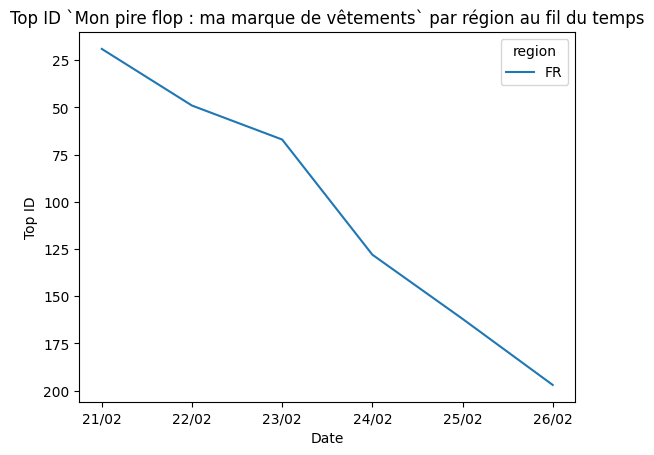

In [20]:
def top_evolution_plot(dt, id):
    data = dt[dt['id'] == id]
    data['fetchedDate'] = pd.to_datetime(data['fetchedDate'])
    data['fetchedDate'] = data['fetchedDate'].dt.strftime('%d/%m')
    
    sns.lineplot(data=data[['fetchedDate', 'topID', 'region']], x='fetchedDate', y='topID', hue='region')
    plt.xlabel('Date')
    plt.ylabel('Top ID')
    plt.title(f"Top ID `{data['title'].values[0]}` par région au fil du temps")
    plt.gca().invert_yaxis()
    plt.show()

top_evolution_plot(df, 'dIlbshbTRlQ')

/tmp/ipykernel_354/985043909.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['fetchedDate'] = pd.to_datetime(dt['fetchedDate'])
/tmp/ipykernel_354/985043909.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['fetchedDate'] = dt['fetchedDate'].dt.strftime('%d/%m')
/tmp/ipykernel_354/985043909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

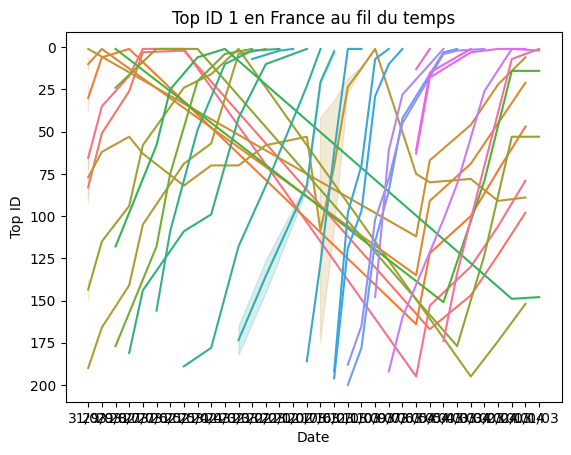

In [21]:
dt = df[df['region'] == 'FR']
top1ID = dt[dt['topID'] == 1]['id'].values
# print(top1ID)
dt = df[df['id'].isin(top1ID)]
dt['fetchedDate'] = pd.to_datetime(dt['fetchedDate'])
dt['fetchedDate'] = dt['fetchedDate'].dt.strftime('%d/%m')
dt.sort_values(by=['fetchedDate'], ascending=False, inplace=True)

sns.lineplot(data=dt[['fetchedDate', 'topID', 'title']], x='fetchedDate', y='topID', hue='title', legend=False)
plt.xlabel('Date')
plt.ylabel('Top ID')
plt.title(f"Top ID 1 en France au fil du temps")
plt.gca().invert_yaxis()
plt.show()
# dt

In [22]:
df['fetchedDate'].sort_values(ascending=False).unique()

array(['2024-04-06 14:38:16.164265', '2024-04-05 00:41:38.708229',
       '2024-04-03 23:04:01.394808', '2024-04-02 23:29:54.903796',
       '2024-04-01 23:07:29.132768', '2024-03-31 23:45:15.219420',
       '2024-03-31 13:23:29.364384', '2024-03-29 23:24:02.778160',
       '2024-03-28 13:34:23.448182', '2024-03-27 09:23:04.989974',
       '2024-03-25 22:33:05.824474', '2024-03-24 23:21:37.574989',
       '2024-03-23 00:53:19.020756', '2024-03-22 01:18:57.536656',
       '2024-03-20 00:22:03.600791', '2024-03-17 23:55:09.934298',
       '2024-03-16 17:46:13.964473', '2024-03-12 22:52:45.019757',
       '2024-03-11 23:10:48.745787', '2024-03-10 16:37:05.194697',
       '2024-03-09 01:33:40.918440', '2024-03-07 23:44:07.742057',
       '2024-03-05 21:38:17.516520', '2024-03-04 21:21:05.213660',
       '2024-03-03 19:01:02.117072', '2024-03-02 18:04:55.577168',
       '2024-03-01 23:24:35.000000', '2024-02-29 15:44:21.000000',
       '2024-02-27 23:20:00.000000', '2024-02-26 22:28:37.0000